In [114]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import copy
from astropy.io import fits
import lightkurve as lk
import random

from EightBitTransit.cTransitingImage import TransitingImage
from EightBitTransit.inversion import *
from EightBitTransit.misc import *

import scipy.interpolate as interp
import scipy
from scipy.optimize import curve_fit 

from PIL import Image
from PIL import ImageDraw
from PIL import ImageChops

%matplotlib inline

In [126]:
mag_plot = {}
mag_plot['mag'] = []
mag_plot['observ'] = []
mag_plot['circ_at_threshold'] = []

In [127]:
mag_arr = np.array([8.7, 9., 9.5, 10., 10.5, 11., 11.5, 12., 12.5, 13., 13.5, 14., 14.5, 15., 15.5])

/Users/piperfrances/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:103: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/Users/piperfrances/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:111: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/Users/piperfrances/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:128: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/Users/piperfrances/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:129: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/Users/piperfrances/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:224: RankWarning: Polyfit may be poorly conditioned


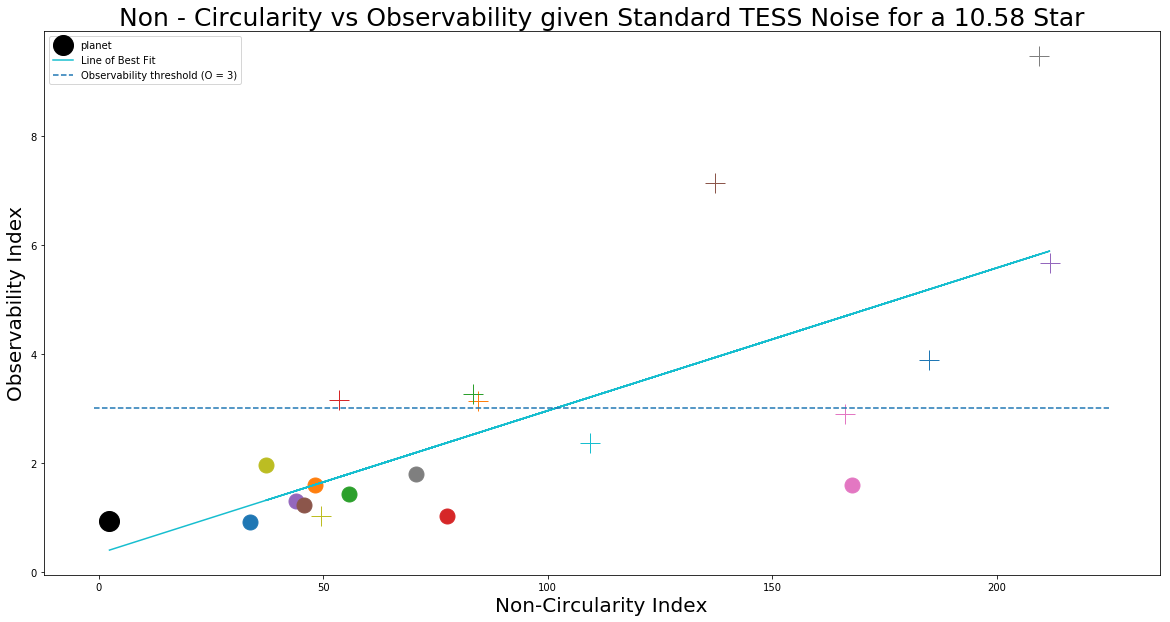

In [170]:
mag_arr = [10.58,]
for mag in mag_arr:
    circ_plot = {}
    circ_plot['mag'] = []
    circ_plot['circ'] = []
    circ_plot['observ'] = []
    circ_plot['label'] = []
    circ_plot['label'] = ["planet", "blocky planet", "blockier planet", "planet with large moon", "triangular shard", "pentagon", "triangle", "bars", "crescent moon", "square frame", "x", "two planets", "rodent spaceship", "elongated hexagon", "two rectangles", "prime number bars", "dust patches", "checkerboard frame", "semi-circles", "diamond"]
    
    i = -1
    while i < 19:
        if i == -1:
            name = "planet"
        else:
            name = str(i)
        
        first_im = Image.open("/Users/piperfrances/BSRC/code/circularity/circ_inputs/"+name+".png").convert('LA').convert('RGB')
        arr = np.array(Image.fromarray(np.asarray(first_im)).resize((100,100)))
        img = Image.fromarray(arr)
        
        immat = img.load()
        (X, Y) = img.size
        m = np.zeros((X, Y))
        area = 0

        for x in range(X):
            for y in range(Y):
                m[x, y] = immat[(x, y)] != (255, 255, 255)
                if immat[(x, y)] == (0, 0, 0):
                    #immat[(x, y)] = 0
                    area = area + 1
        m = m / np.sum(np.sum(m))

        # marginal distributions
        dx = np.sum(m, 1)
        dy = np.sum(m, 0)

        # expected values
        cx = np.sum(dx * np.arange(X))
        cy = np.sum(dy * np.arange(Y))
        
        # now we create a planetary object that's the same number of pixels
        r = np.sqrt((area / np.pi))
        size = (X, Y)
        planimg = Image.new('L', size, color=10000000).convert('LA').convert('RGB')
        draw = ImageDraw.Draw(planimg)

        leftUpPoint = (cx-r, cy-r)
        rightDownPoint = (cx+r, cy+r)
        twoPointList = [leftUpPoint, rightDownPoint]
        draw.ellipse(twoPointList, 0, 0,)
        
        planArr = np.array(Image.fromarray(np.asarray(planimg)))

        sub_arr = np.subtract(planArr, arr)
        
        sub_i = ImageChops.add(planimg, img, scale = 2.0, offset = 0)
        
        (sx, sy, sz) = sub_arr.shape
        (subX, subY) = sub_i.size
        
        sub_img = Image.fromarray(sub_arr)
        
        num_dif = 0
        # for x in range(sx):
        #     for y in range(sy):
        #         for z in range(sz):
        #             if arr[x][y][z] > 100:
        #                 num_dif = num_dif + 1

        black = 0
        white = 0
        gray = 0
        other = 0
        p_list = []
        for pixel in sub_i.getdata():
            if pixel == (0, 0, 0): # if your image is RGB (if RGBA, (0, 0, 0, 255) or so
                black += 1
            if pixel == (127, 127, 127):
                gray += 1
            if pixel == (255, 255, 255): # if your image is RGB (if RGBA, (0, 0, 0, 255) or so
                white += 1
            else:
                other += 1
                p_list = np.append(p_list, pixel)
                
        percent_dif = (gray / area) * 100
        
        img_file = "/Users/piperfrances/BSRC/code/circularity/artifact.png"
        planet_file = "/Users/piperfrances/BSRC/code/circularity/planet.png"
        sub_file = "/Users/piperfrances/BSRC/code/circularity/subtraction.png"
        img.save(img_file,)
        planimg.save(planet_file,)
        sub_img.save(sub_file,)
        
        times = np.linspace(-35.,35.,500)
        artificial_lowres_SItitle = TransitingImage(imfile=img_file,
                                            lowres=100,
                                            lowrestype="mean", # Calculate the lower-resolution version of the image by averaging "neighborhoods" of pixels in the high-res image.
                                            lowresround=False, # Let the resulting low-res pixel values take on intermediate values between 0 and 1, i.e. don't round them to 0 or 1.
                                            v=0.4,
                                            t_ref=0.,
                                            t_arr=times)

        planet_lowres_SItitle = TransitingImage(imfile=planet_file,
                                            lowres=100,
                                            lowrestype="mean", # Calculate the lower-resolution version of the image by averaging "neighborhoods" of pixels in the high-res image.
                                            lowresround=False, # Let the resulting low-res pixel values take on intermediate values between 0 and 1, i.e. don't round them to 0 or 1.
                                            v=0.4,
                                            t_ref=0.,
                                            t_arr=times)

        m = 0.0006149042851666919 # as derived from TESS data
        b = -0.005250374227956735
        #mag_rand = random.uniform(8.5, 15.5)
        mag_rand = mag
        circ_plot['mag'] = mag_rand
        stdev = ( mag_rand * m + b )
        num_points = 72

        mu, sigma = 1, stdev 
        # creating a noise with the same dimension as the dataset (1,1) 
        planet_noise = np.random.normal(mu, sigma, [int(num_points),]) 
        artif_noise = np.random.normal(mu, sigma, [int(num_points),]) 

        #lowres_SItitle.plot_grid()
        #print np.shape(lowres_SItitle.opacitymat)
        artificial_lowres_SItitle_LC, overlapTimes = artificial_lowres_SItitle.gen_LC(t_arr=times)  
        planet_lowres_SItitle_LC, overlapTimes = planet_lowres_SItitle.gen_LC(t_arr=times) 

        non_transit = np.linspace(1.,1.,int(num_points/2))

        non_t_noise_before_planet = np.random.normal(mu, sigma, [int(num_points/2),]) 
        non_t_noise_after_planet = np.random.normal(mu, sigma, [int(num_points/2),])

        non_t_noise_before_artif = np.random.normal(mu, sigma, [int(num_points/2),]) 
        non_t_noise_after_artif = np.random.normal(mu, sigma, [int(num_points/2),])

        before_p = non_t_noise_before_planet * non_transit
        after_p = non_t_noise_after_planet * non_transit

        before_a = non_t_noise_before_artif * non_transit
        after_a = non_t_noise_after_artif * non_transit

        planet_LC = []
        planet_LC = np.append(planet_LC, before_p)
        planet_LC = np.append(planet_LC, planet_lowres_SItitle_LC*planet_noise)
        planet_LC = np.append(planet_LC, after_p)

        artif_LC = []
        artif_LC = np.append(artif_LC, before_a)
        artif_LC = np.append(artif_LC, artificial_lowres_SItitle_LC*artif_noise)
        artif_LC = np.append(artif_LC, after_a)

        # interpolating the smaller array
        times_interp = interp.interp1d(np.arange(overlapTimes.size),overlapTimes)
        times_stretch = times_interp(np.linspace(0,overlapTimes.size-1,planet_LC.size))

#         fig, ax = plt.subplots(1,1,figsize=(16,6))
#         ax = plt.axes()
#         ax.plot(times_stretch,artif_LC,'o',color="blue",label = "artificial transit")
#         ax.plot(times_stretch,planet_LC,'o',color="magenta",label = "planetary transit")
#         plt.xlabel("Time [days]",fontsize=14)
#         plt.ylabel("Relative flux",fontsize=14)
#         plt.title(r"Same Size Artificial and Planetary Objects Transiting in Front of a "+str(mag_rand)+" Star",fontsize=16)
#         ax1 = plt.axes([.65, .2, 0.2, 0.2])
#         ax1.imshow(artificial_lowres_SItitle.opacitymat,cmap="Greys",aspect="equal",origin="upper",interpolation='none',vmin=0.,vmax=1.)
#         #ax1.plot(cx,cy,'.',color ="red")
#         ax1.set_title("Artificial Object")
#         ax3 = plt.axes([.75, .2, 0.2, 0.2])
#         ax3.imshow(planet_lowres_SItitle.opacitymat,cmap="Greys",aspect="equal",origin="upper",interpolation='none',vmin=0.,vmax=1.)
#         #ax3.plot(cx,cy,'.',color ="red")
#         ax3.set_title("Planetary Object")
#         ax.legend()

#         words_ax = plt.axes([.5, -.14, 0.0, 0.0])
#         words_ax.axis("off")
#         words_ax.set_title("Difference in Circularity between Artificial and Planetary Object: "+str(percent_dif)+"%",fontsize=15)

#         filename = "/Users/piperfrances/BSRC/code/circularity/LCs/" + name
#         plt.savefig(filename, fmt="png")

#         fig2, ax6 = plt.subplots(1,1,figsize=(16,6))
#         ax6 = plt.axes()
#         ax6.plot(times_stretch,(artif_LC - planet_LC),'o',color="red",label = "artificial transit - planetary transit")
#         plt.xlabel("Time [days]",fontsize=14)
#         plt.ylabel("Relative flux",fontsize=14)
#         plt.title(r"Subtraction of Objects Transiting in Front of a "+str(mag_rand)+" Star",fontsize=16)
#         ax7 = plt.axes([.65, .2, 0.2, 0.2])
#         ax7.imshow(artificial_lowres_SItitle.opacitymat,cmap="Greys",aspect="equal",origin="upper",interpolation='none',vmin=0.,vmax=1.)
#         #ax1.plot(cx,cy,'.',color ="red")
#         ax7.set_title("Artificial Object")
#         ax8 = plt.axes([.75, .2, 0.2, 0.2])
#         ax8.imshow(planet_lowres_SItitle.opacitymat,cmap="Greys",aspect="equal",origin="upper",interpolation='none',vmin=0.,vmax=1.)
#         #ax3.plot(cx,cy,'.',color ="red")
#         ax8.set_title("Planetary Object")
#         ax6.legend()

#         words_ax1 = plt.axes([.5, -.14, 0.0, 0.0])
#         words_ax1.axis("off")
#         words_ax1.set_title("Difference in Circularity between Artificial and Planetary Object: "+str(percent_dif)+"%",fontsize=15)

        filename = "/Users/piperfrances/BSRC/code/circularity/LCs/sub" + name
        #plt.savefig(filename, fmt="png")
        plt.show()
        plt.close()

        # rms is the square root of the mean of the data
        non_t = []
        non_t = np.append(non_t, (artif_LC - planet_LC)[0:int(num_points/2)])
        non_t = np.append(non_t, (artif_LC - planet_LC)[int(num_points/2 + num_points):])

        t = (artif_LC - planet_LC)[int(num_points/2):int(num_points/2 + num_points)]

        non_t_rms = np.sqrt(np.mean(non_t**2))
        t_rms = np.sqrt(np.mean(t**2))
        observability = t_rms / non_t_rms
        circ_plot['observ'] = np.append(circ_plot['observ'], observability)
        circ_plot['circ'] = np.append(circ_plot['circ'], percent_dif)
        #circ_plot['label'] = np.append(circ_plot['label'], label)

        y = circ_plot['observ']
        x = circ_plot['circ']
        m, b = np.polyfit(x, y, 1)
        
        
        i = i + 1

#     plt.figure(figsize=(18,8))
#     plt.title("Circularity vs Observability given Standard TESS Noise for a "+str(circ_plot['mag'])+" Star")
#     for i in range(len(circ_plot['label'])):
#         plt.plot(circ_plot['circ'][i],circ_plot['observ'][i],'o',label=str(circ_plot['label'][i]))
#     plt.plot(x, (x*m)+b,'-',label="is the object observable?")
#     plt.legend()
#     plt.ylabel("Observability ([rms inside transit / rms outside transit] - 1)")
#     plt.xlabel("Circularity (pixels outside of circular shape / area of circle)")
#     plt.show()
    
    plt.figure(figsize=(20,10))
    plt.title("Non - Circularity vs Observability given Standard TESS Noise for a "+str(circ_plot['mag'])+" Star",fontsize=25)
    for i in range(len(circ_plot['label'])):
        if i == 0:
            plt.plot(circ_plot['circ'][i],circ_plot['observ'][i],'o',markersize=20,color='black',label=str(circ_plot['label'][i]))
        else:
            if i < 10:
                if i % 2 == 0:
                    plt.plot(circ_plot['circ'][i],circ_plot['observ'][i],'o',markersize=15)
                else:
                    plt.plot(circ_plot['circ'][i],circ_plot['observ'][i],'o',markersize=15)
            else:
                if i % 2 == 0:
                    plt.plot(circ_plot['circ'][i],circ_plot['observ'][i],'+',markersize=20)
                else:
                    plt.plot(circ_plot['circ'][i],circ_plot['observ'][i],'+',markersize=20)
    plt.plot(x, (x*m)+b,'-',label="Line of Best Fit")
    plt.plot(np.linspace(-1,225, 200),np.linspace(3,3,200), '--', label="Observability threshold (O = 3)")
    plt.legend()
    plt.ylabel("Observability Index",fontsize=20)
    plt.xlabel("Non-Circularity Index",fontsize=20)
    filename = "/Users/piperfrances/Downloads/shapes_observ"
    plt.savefig(filename, fmt="png")
    plt.show()

    mag_plot['mag'] = np.append(mag_plot['mag'], mag)
    
    mag_plot['circ_at_threshold'] = np.append(mag_plot['circ_at_threshold'], (3-b)/m)

    mag_plot['observ'] = np.append(mag_plot['observ'], m)
    

Text(0,0.5,'Slope of Circularity vs. Observability')

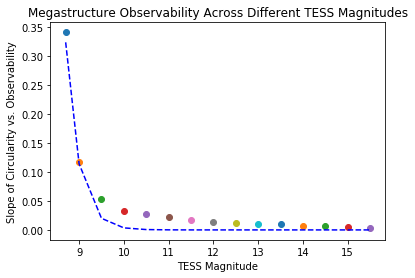

In [129]:
plt.title("Megastructure Observability Across Different TESS Magnitudes")
for i in range(len(mag_plot['mag'])):
    plt.plot(mag_plot['mag'][i], mag_plot['observ'][i], 'o')

y = mag_plot['observ']
x = mag_plot['mag']
# m,b = np.polyfit(x, np.log(y), 1)

def func(x, a, b, c):
    return a * np.exp(b * x) + c
    

val, val2 = curve_fit(func, x, y, p0=[0.01,0.0,0.01], maxfev=100000)

plt.plot(x, val[0]*np.exp(x*val[1]), '--', color = "blue")

plt.xlabel("TESS Magnitude")
plt.ylabel("Slope of Circularity vs. Observability")

<Figure size 432x288 with 0 Axes>

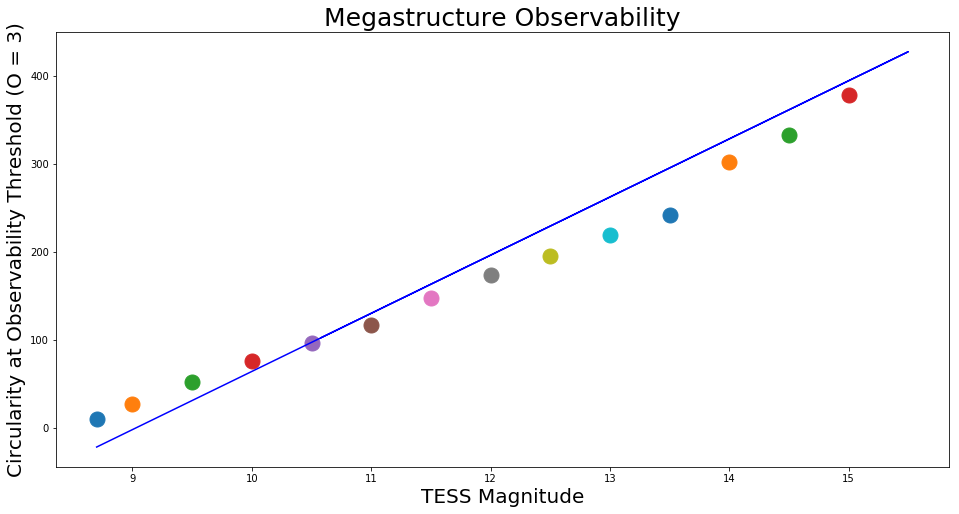

In [156]:
plt.clf()
plt.figure(figsize=(16,8))
plt.title("Megastructure Observability",fontsize=25)
for i in range(len(mag_plot['mag']) - 3):
    plt.plot(mag_plot['mag'][i], mag_plot['circ_at_threshold'][i], 'o',markersize=15)

y = mag_plot['circ_at_threshold']
x = mag_plot['mag']
m,b = np.polyfit(x, y, 1)

# def func(x, a, b, c):
#     return a * np.exp(b * x) + c
    

# val, val2 = curve_fit(func, x, y, p0=[0.01,0.0,0.01], maxfev=100000)

# words_ax1 = plt.axes([.5, -.14, 0.0, 0.0])
# words_ax1.axis("off")
# words_ax1.set_title("Observability threshold (O = 3) is calculated based on:")

# words_ax2 = plt.axes([.5, -.20, 0.0, 0.0])
# words_ax2.axis("off")
# words_ax2.set_title("(RMS of subtraction between [artificial-planetary] in-transit points)")

# words_ax3 = plt.axes([.5, -.26, 0.0, 0.0])
# words_ax3.axis("off")
# words_ax3.set_title("——————————————————————————————————————————————————————————————————————")

# words_ax4 = plt.axes([.5, -.32, 0.0, 0.0])
# words_ax4.axis("off")
# words_ax4.set_title("(RMS of subtraction between [artificial-planetary] out-of-transit points)")

plt.plot(x, m*x + b, '-', color = "blue",label="Line of Best Fit")

plt.xlabel("TESS Magnitude",fontsize=20)
plt.ylabel("Circularity at Observability Threshold (O = 3)",fontsize=20)
filename = "/Users/piperfrances/Downloads/Megastructure_observ"
plt.savefig(filename, fmt="png")
plt.show()

In [53]:
print("Welcome to the TESS circularity and observability index calculator!")

Welcome to the TESS circularity and observability index calculator!


In [87]:
input_mag = 8.7

circ_slope = val[0]*np.exp( input_mag *val[1])

# Observable things have a circularity above 2.38
# x = 2.38
observability = circ_slope * 2.38

In [88]:
observability

0.8898495276713686

In [89]:
circ_index = []
input_mags = np.linspace(8.7, 15.5, 100)

for c in range(len(input_mags)):
    cir_s = val[0]*np.exp( input_mags[c] *val[1])
    circ_index = np.append(circ_index, (cir_s* 2.38))


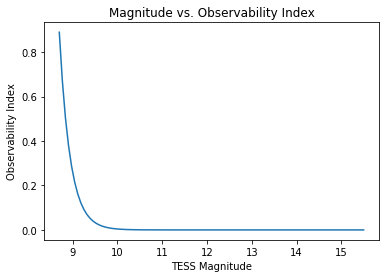

In [90]:
plt.title("Magnitude vs. Observability Index")
plt.xlabel("TESS Magnitude")
plt.ylabel("Observability Index")
plt.plot(input_mags, circ_index)

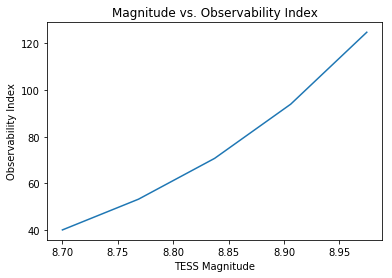

In [86]:
plt.title("Magnitude vs. Observability Index")
plt.xlabel("TESS Magnitude")
plt.ylabel("Observability Index")
plt.plot(input_mags[0:5], circ_index[0:5])